# This script synchronizes the AUV in-situ measurements

---

#### Author: Yaolin Ge
#### Contact: yaolin.ge@ntnu.no
#### Date: 2022-11-14

---

## It consists of three steps

- Step I: extract raw data from sensor array. 
- Step II: synchronize raw data with timestamps. 
- Step III: Merge all data together


In [9]:
import os
import re
import pandas as pd
import numpy as np
import time
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

datapath = os.getcwd() + "/../../../../Data/Porto/20221111/logs/merged/mra/csv/"


# Step I: extract raw data

In [10]:
#% Data extraction from the raw data
rawLoc = pd.read_csv(datapath + "EstimatedState.csv", delimiter=', ', header=0, engine='python')
rawSal = pd.read_csv(datapath + "Salinity.csv", delimiter=', ', header=0, engine='python')
rawDepth = pd.read_csv(datapath + "Depth.csv", delimiter=', ', header=0, engine='python')

# To group all the time stamp together, since only second accuracy matters
rawSal.iloc[:, 0] = np.ceil(rawSal.iloc[:, 0])
rawLoc.iloc[:, 0] = np.ceil(rawLoc.iloc[:, 0])
rawDepth.iloc[:, 0] = np.ceil(rawDepth.iloc[:, 0])
rawDepth.iloc[:, 0] = np.ceil(rawDepth.iloc[:, 0])

# Step II: synchronize with timestamps

In [11]:
lat_origin = rawLoc["lat (rad)"].groupby(rawLoc["timestamp (seconds since 01/01/1970)"]).mean()
lon_origin = rawLoc["lon (rad)"].groupby(rawLoc["timestamp (seconds since 01/01/1970)"]).mean()
x_loc = rawLoc["x (m)"].groupby(rawLoc["timestamp (seconds since 01/01/1970)"]).mean()
y_loc = rawLoc["y (m)"].groupby(rawLoc["timestamp (seconds since 01/01/1970)"]).mean()
z_loc = rawLoc["z (m)"].groupby(rawLoc["timestamp (seconds since 01/01/1970)"]).mean()
depth = rawLoc["depth (m)"].groupby(rawLoc["timestamp (seconds since 01/01/1970)"]).mean()
time_loc = rawLoc["timestamp (seconds since 01/01/1970)"].groupby(rawLoc["timestamp (seconds since 01/01/1970)"]).mean()
time_sal= rawSal["timestamp (seconds since 01/01/1970)"].groupby(rawSal["timestamp (seconds since 01/01/1970)"]).mean()
dataSal = rawSal["value"].groupby(rawSal["timestamp (seconds since 01/01/1970)"]).mean()



# Step III: merge all synchronized data

In [12]:
circumference = 40075000
data = []
time_mission = []
xauv = []
yauv = []
zauv = []
dauv = []
sal_auv = []
lat_auv = []
lon_auv = []

for i in range(len(time_loc)):
    if np.any(time_sal.isin([time_loc.iloc[i]])):
        time_mission.append(time_loc.iloc[i])
        xauv.append(x_loc.iloc[i])
        yauv.append(y_loc.iloc[i])
        zauv.append(z_loc.iloc[i])
        dauv.append(depth.iloc[i])
        lat_temp = np.rad2deg(lat_origin.iloc[i]) + np.rad2deg(x_loc.iloc[i] * np.pi * 2.0 / circumference)
        lat_auv.append(lat_temp)
        lon_auv.append(np.rad2deg(lon_origin.iloc[i]) + np.rad2deg(y_loc.iloc[i] * np.pi * 2.0 / (circumference * np.cos(np.deg2rad(lat_temp)))))
        sal_auv.append(dataSal[time_sal.isin([time_loc.iloc[i]])].iloc[0])
    else:
        print(datetime.fromtimestamp(time_loc.iloc[i]))
        continue



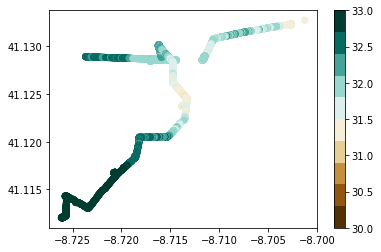

In [13]:
plt.scatter(lon_auv, lat_auv, c=sal_auv, cmap=get_cmap("BrBG", 10), vmin=30, vmax=33)
plt.colorbar()

In [33]:
dataset = np.stack((time_mission, lat_auv, lon_auv, dauv, sal_auv), axis=1)
df = pd.DataFrame(dataset, columns=['timestamp', 'lat', 'lon', 'depth', 'salinity'])
df.to_csv("csv/AUVData.csv", index=False)